In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from mpl_toolkits.mplot3d import Axes3D

### Exercise 11.3

In [2]:
# Superparameters
# (Common parameters for all models)
n_epochs = 40
n_training_data = 15000
n_validation_data = 5000
x_min, x_max = -3/2, 3/2
y_min, y_max = -3/2, 3/2
noise = 0.1
np.random.seed(0)

def target_fn(x):
    return np.sin(x[0]**2 + x[1]**2)

def create_grid(n_points):
    # Generates n_points (x,y) couples, randomly
    # distributed in the [x_min,x_max]*[y_min,y_max]
    # square.
    r = np.array([
        np.random.uniform(x_min, x_max, n_points),
        np.random.uniform(y_min, y_max, n_points)
    ])
    return r.T

In [3]:
# Generate training inputs, drawing points uniformly
# from the [x_min ,x_max] * [y_min, y_max] square.
in_training   = create_grid(n_training_data)
in_validation = create_grid(n_validation_data)

out_training   = np.random.normal([target_fn(x) for x in in_training], noise)
out_validation = np.random.normal([target_fn(x) for x in in_validation], noise)

in_target  = in_validation
out_target = target_fn(in_target)

In [4]:
class neural_network:
    def __init__(self, layers, optimizer_fn, loss_fn):
        self.optimizer_fn = optimizer_fn
        self.loss_fn = loss_fn
        self.network = Sequential()
        self.layers_size = [item[0] for item in layers]
        self.activation_functions = [item[1] for item in layers]

###### Definition of the neural networks

In [5]:
features = [
    ([(8, "tanh"), (1, "linear")], "adadelta", "mse"),# probably the best
    ([(8, "tanh"), (1, "linear")], "sgd", "mse"), # could be better
    ([(4, "tanh"), (4, "tanh"), (1, "linear")], "sgd", "mse"), # close second?
    ([(4, "tanh"), (1, "relu")], "sgd", "mse"), # not good
    ([(4, "tanh"), (1, "relu")], "sgd", "mse"), # sometimes okay
    ([(4, "tanh"), (1, "linear")], "adagrad", "mse"), # no...
]
models = [neural_network(layers, optimizer_fn, loss_fn) for layers, optimizer_fn, loss_fn in features]
for model in models:
    for n in range(len(model.layers_size)):
        if n == 0:
            model.network.add(Dense(
                model.layers_size[n],
                input_shape = (2,),
                activation = model.activation_functions[n]
            ))
        else:
            model.network.add(Dense(
                model.layers_size[n],
                activation = model.activation_functions[n]
            ))

###### Training

In [6]:
model_histories = []
for model in models:
    # Compile the model choosing the optimizer, loss and metrics objects.
    model.network.compile(optimizer = model.optimizer_fn, loss = model.loss_fn, metrics = ["mse"])

    # Evaluate the model using the "training" dataset,
    # over epochs of 32 batch size each.
    model_histories.append(model.network.fit(
        x = in_training,
        y = out_training,
        batch_size = 32,
        epochs = n_epochs,
        shuffle = True, # It is a good idea to shuffle the input before each epoch.
        validation_data = (in_validation, out_validation),
        callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss')] # Use default parameters.
    ))

Train on 15000 samples, validate on 5000 samples
Epoch 1/40
15000/15000 [==============================] - 1s 50us/step - loss: 0.2405 - mean_squared_error: 0.2405 - val_loss: 0.1575 - val_mean_squared_error: 0.1575
Epoch 2/40
15000/15000 [==============================] - 0s 17us/step - loss: 0.1637 - mean_squared_error: 0.1637 - val_loss: 0.1539 - val_mean_squared_error: 0.1539
Epoch 3/40
15000/15000 [==============================] - 0s 17us/step - loss: 0.1614 - mean_squared_error: 0.1614 - val_loss: 0.1523 - val_mean_squared_error: 0.1523
Epoch 4/40
15000/15000 [==============================] - 0s 18us/step - loss: 0.1600 - mean_squared_error: 0.1600 - val_loss: 0.1512 - val_mean_squared_error: 0.1512
Epoch 5/40
15000/15000 [==============================] - 0s 16us/step - loss: 0.1581 - mean_squared_error: 0.1581 - val_loss: 0.1484 - val_mean_squared_error: 0.1484
Epoch 6/40
15000/15000 [==============================] - 0s 18us/step - loss: 0.1557 - mean_squared_error: 0.1557 -

15000/15000 [==============================] - 1s 61us/step - loss: 0.1140 - mean_squared_error: 0.1140 - val_loss: 0.1060 - val_mean_squared_error: 0.1060
Epoch 23/40
15000/15000 [==============================] - 1s 59us/step - loss: 0.1123 - mean_squared_error: 0.1123 - val_loss: 0.1044 - val_mean_squared_error: 0.1044
Epoch 24/40
15000/15000 [==============================] - 1s 87us/step - loss: 0.1108 - mean_squared_error: 0.1108 - val_loss: 0.1032 - val_mean_squared_error: 0.1032
Epoch 25/40
15000/15000 [==============================] - 1s 70us/step - loss: 0.1094 - mean_squared_error: 0.1094 - val_loss: 0.1022 - val_mean_squared_error: 0.1022
Epoch 26/40
15000/15000 [==============================] - 1s 64us/step - loss: 0.1082 - mean_squared_error: 0.1082 - val_loss: 0.1006 - val_mean_squared_error: 0.1006
Epoch 27/40
15000/15000 [==============================] - 1s 58us/step - loss: 0.1072 - mean_squared_error: 0.1072 - val_loss: 0.0996 - val_mean_squared_error: 0.0996
Epoc

15000/15000 [==============================] - 1s 56us/step - loss: 0.1121 - mean_squared_error: 0.1121 - val_loss: 0.1080 - val_mean_squared_error: 0.1080
Epoch 31/40
15000/15000 [==============================] - 1s 64us/step - loss: 0.1104 - mean_squared_error: 0.1104 - val_loss: 0.1068 - val_mean_squared_error: 0.1068
Epoch 32/40
15000/15000 [==============================] - 1s 79us/step - loss: 0.1088 - mean_squared_error: 0.1088 - val_loss: 0.1053 - val_mean_squared_error: 0.1053
Epoch 33/40
15000/15000 [==============================] - 1s 86us/step - loss: 0.1074 - mean_squared_error: 0.1074 - val_loss: 0.1040 - val_mean_squared_error: 0.1040
Epoch 34/40
15000/15000 [==============================] - 1s 66us/step - loss: 0.1061 - mean_squared_error: 0.1061 - val_loss: 0.1031 - val_mean_squared_error: 0.1031
Epoch 35/40
15000/15000 [==============================] - 1s 71us/step - loss: 0.1050 - mean_squared_error: 0.1050 - val_loss: 0.1020 - val_mean_squared_error: 0.1020
Epoc

15000/15000 [==============================] - 0s 17us/step - loss: 0.1618 - mean_squared_error: 0.1618 - val_loss: 0.1539 - val_mean_squared_error: 0.1539
Epoch 39/40
15000/15000 [==============================] - 0s 17us/step - loss: 0.1618 - mean_squared_error: 0.1618 - val_loss: 0.1539 - val_mean_squared_error: 0.1539
Epoch 40/40
15000/15000 [==============================] - 0s 16us/step - loss: 0.1617 - mean_squared_error: 0.1617 - val_loss: 0.1538 - val_mean_squared_error: 0.1538


###### Evaluation on test data and predictions

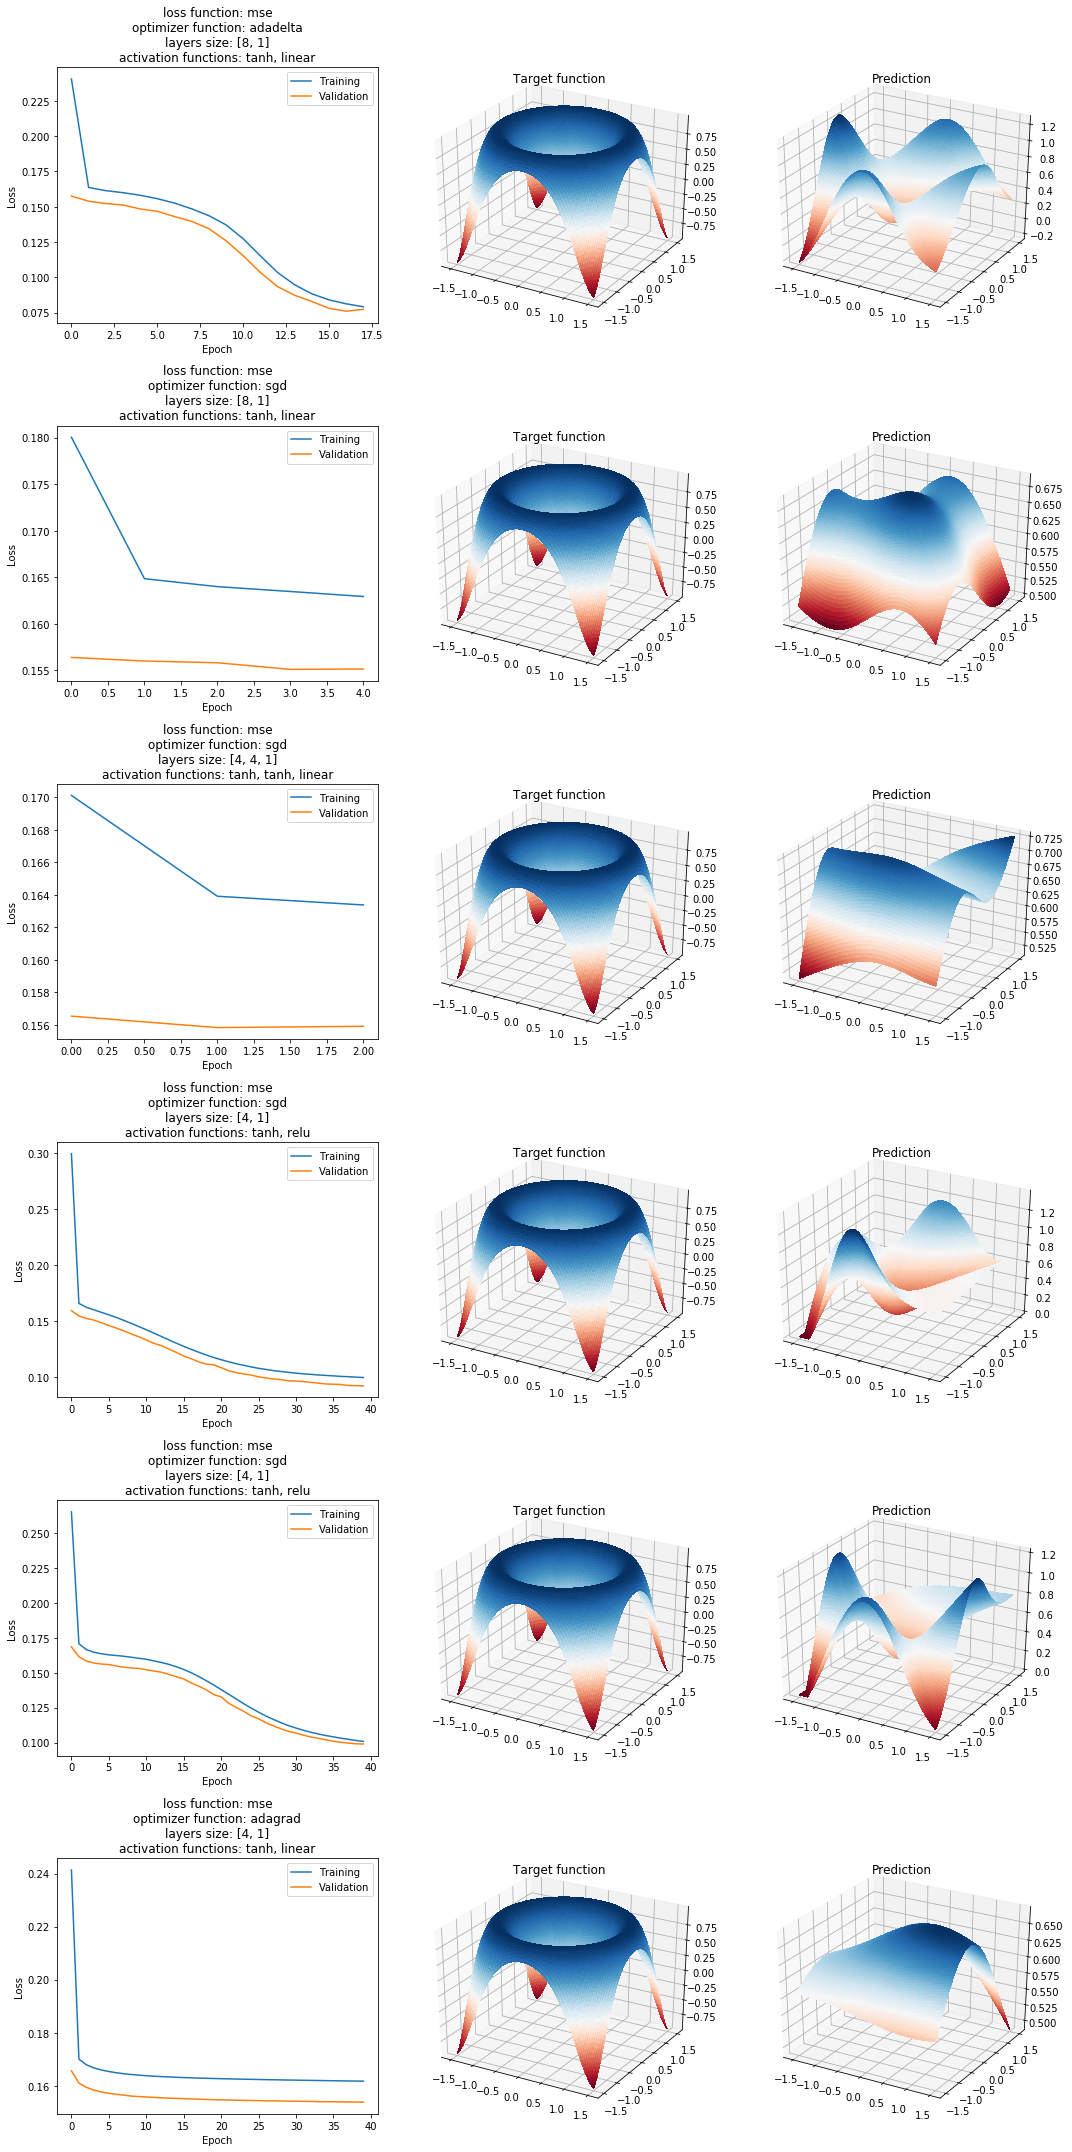

In [7]:
# Plot training info and compare predictions to target data.
fig = plt.figure(figsize = (15, 5 * len(models)))

def target_fn_alt(x, y):
    # Enable target_fn to work with meshgrids.
    return target_fn([x, y])

for i, (model, history) in enumerate(zip(models, model_histories)):
    # Validation results
    ax = fig.add_subplot(len(models), 3, 3 * i + 1)
    ax.plot(history.history["loss"])
    ax.plot(history.history["val_loss"])
    ax.set_title(
        "loss function: " + model.loss_fn
        + "\noptimizer function: " + model.optimizer_fn
        + "\nlayers size: " + str(model.layers_size)
        + "\nactivation functions: " + ", ".join(model.activation_functions)
    )
    ax.set_ylabel("Loss")
    ax.set_xlabel("Epoch")
    ax.legend(["Training", "Validation"], loc = "best")
    
    ax = fig.add_subplot(len(models), 3, 3 * i + 2, projection = "3d")
    ax.set_title("Target function")
    out_predicted = model.network.predict(in_target)
    x = [pt[0] for pt in in_target]
    y = [pt[1] for pt in in_target]
    X, Y = np.meshgrid(
        np.linspace(x_min, x_max, 100),
        np.linspace(y_min, y_max, 100)
    )
    surf = ax.plot_surface(
        X, Y,
        target_fn_alt(X, Y),
        rstride = 1,
        cstride = 1, 
        cmap = plt.cm.RdBu,
        linewidth = 0,
        antialiased = False
    )

    ax = fig.add_subplot(len(models), 3, 3 * i + 3, projection = "3d")
    ax.set_title("Prediction")
    data = []
    for x, y in zip(X.flatten(), Y.flatten()):
        data.append([x, y])
    z = model.network.predict(np.array(data))
    z = z.reshape((100, 100))
    surf = ax.plot_surface(
        X, Y,
        z,
        rstride = 1,
        cstride = 1,
        cmap = plt.cm.RdBu,
        linewidth = 0,
        antialiased = False
    )

fig.tight_layout()
plt.show()

###### Comments
Since a scatter plot would be hard to read, especially when superimposed to the surface plot of the target function (that is the middle plot in the rows above), I chose instead to make the networks produce another surface plot (shown on the right).

I enabled the *early stopping* feature so that the training stops when the accuracy on the validation data stops improving: this may be a good way to prevent overfitting, at the same time reducing the training time.

I tried experimenting with different layer structures, activation and loss functions to see which combination would give the best results.
The cell above lists some of the best results I managed to achieve.
Some remarks I wrote in the previous exercise continue to hold here: large-sized layers do not help, just one middle layer is enough, a combination of *tanh* and *linear* activation functions is probably the best.
The *sgd* optimizer performed generally well, while the other optimizers I used, *adadelta* and *adagrad*, performed in an inconsistent manner when I changes the simulation parameters.

Overall it seems that the networks did a good job on recognising the shape of the data near the edges of the square, but they had more difficulties in sampling correctly the function near the origin, which I believe is due to the fact that it changes more rapidly at the centre than at the border.
None of them, moreover, managed to recognise the circle of maxima of the function.

In the end I would say that the first network (from the top), judging from the accuracy levels it reached and the plots on the right, was the best among those I trained, with the third one in second place (it performed much better than now when the noise level was higher, in previous simulations I did not show here).